In [1]:
#import required libraries
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import math
#import re
import glob
import json
import os
from scipy.stats import pearsonr

#import torch
#import torch.nn as nn
#import torch.nn.functional as F


from NegativeClassOptimization import  visualisations
from NegativeClassOptimization import config, utils
from NegativeClassOptimization import  datasets

Fontconfig warning: ignoring UTF-8: not a valid region tag


In [2]:
pellets = {'color_blind_light':['#a2c8ec','#cfcfcf', '#ffbc79'], 
'color_blind_dark':['#5CA7E5','#ababab', '#ff7700'],
'r_like':['#94669E', '#F2D81D', '#00817A'],
'chat_gpt': ['#FFC300', '#FF5733', '#00A6ED'],
'antigens': ['#008080','#FFA07A','#000080','#FFD700','#228B22','#FF69B4','#800080','#FF6347','#00FF00','#FF1493']}

cmap = { 'vs 9' : '#FF5733',
         'vs Non-binder':'#00A6ED',
         'vs Weak':'#FFC300',
         'vs 1': '#8B5F4D'}
task_2_dataset = {"ONE_VS_NINE": datasets.ClassificationTaskType.ONE_VS_NINE,
"HIGH_VS_95LOW": datasets.ClassificationTaskType.HIGH_VS_95LOW,
"HIGH_VS_LOOSER": datasets.ClassificationTaskType.HIGH_VS_LOOSER}


In [3]:
miniabsolut_path = Path(config.DATA_BASE_PATH/f"MiniAbsolut_Splits/MiniAbsolut_Seed4")
miniabsolut_path

PosixPath('/Users/aygulminnegalieva/Music/nco/negative-class-optimization/data/MiniAbsolut_Splits/MiniAbsolut_Seed4')

In [4]:
#might be needed copied from Eugen
from itertools import permutations


task_types = (
    datasets.ClassificationTaskType.ONE_VS_ONE,
    datasets.ClassificationTaskType.ONE_VS_NINE,
    datasets.ClassificationTaskType.HIGH_VS_95LOW,
    datasets.ClassificationTaskType.HIGH_VS_LOOSER,
)

loader = datasets.FrozenMiniAbsolutMLLoader(
    data_dir=Path(config.DATA_BASE_PATH/"Frozen_MiniAbsolut_ML/")
)

In [7]:
#section 2 main plots
logit_energy_corr_path = config.DATA_BASE_PATH/"07e_LogitEnergyCorrelations.tsv"
df_logits = pd.read_csv(logit_energy_corr_path, sep="\t")
df_logits_old = pd.read_csv(config.DATA_BASE_PATH/"07e_LogitEnergyCorrelations_old.tsv", sep="\t")
df_logits_new = pd.concat(
    [
        df_logits.query("task_type == '1v1'").copy(),
        df_logits_old.query("task_type != '1v1'").copy(),
    ],
    axis=0
)
df_logits_new.task_type.value_counts()
df_logits = df_logits_new.copy()

In [8]:
# Correct for double antigen contribution from 1v1 (to pos and negative, symmetric)
df_logits_1v1 = df_logits.loc[df_logits["task_type"] == "1v1"].copy()
ag_pos_series = df_logits_1v1["ag_pos"]
df_logits_1v1["ag_pos"] = df_logits_1v1["ag_neg"]
df_logits_1v1["ag_neg"] = ag_pos_series
del ag_pos_series
df_logits = pd.concat([df_logits, df_logits_1v1], axis=0)

In [9]:
task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]

In [10]:
ag_order = [
        "1FBI",
        "3VRL",
        "2YPV",
        "5E94",
        "1WEJ",
        "1OB1",
        "1NSN",
        "1H0D",
        "3RAJ",
        "1ADQ",
    ]

In [11]:
cmap_ag = dict(zip(ag_order, pellets['antigens']))

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_79332/1807947238.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))


Text(0.5, 0, 'Task')

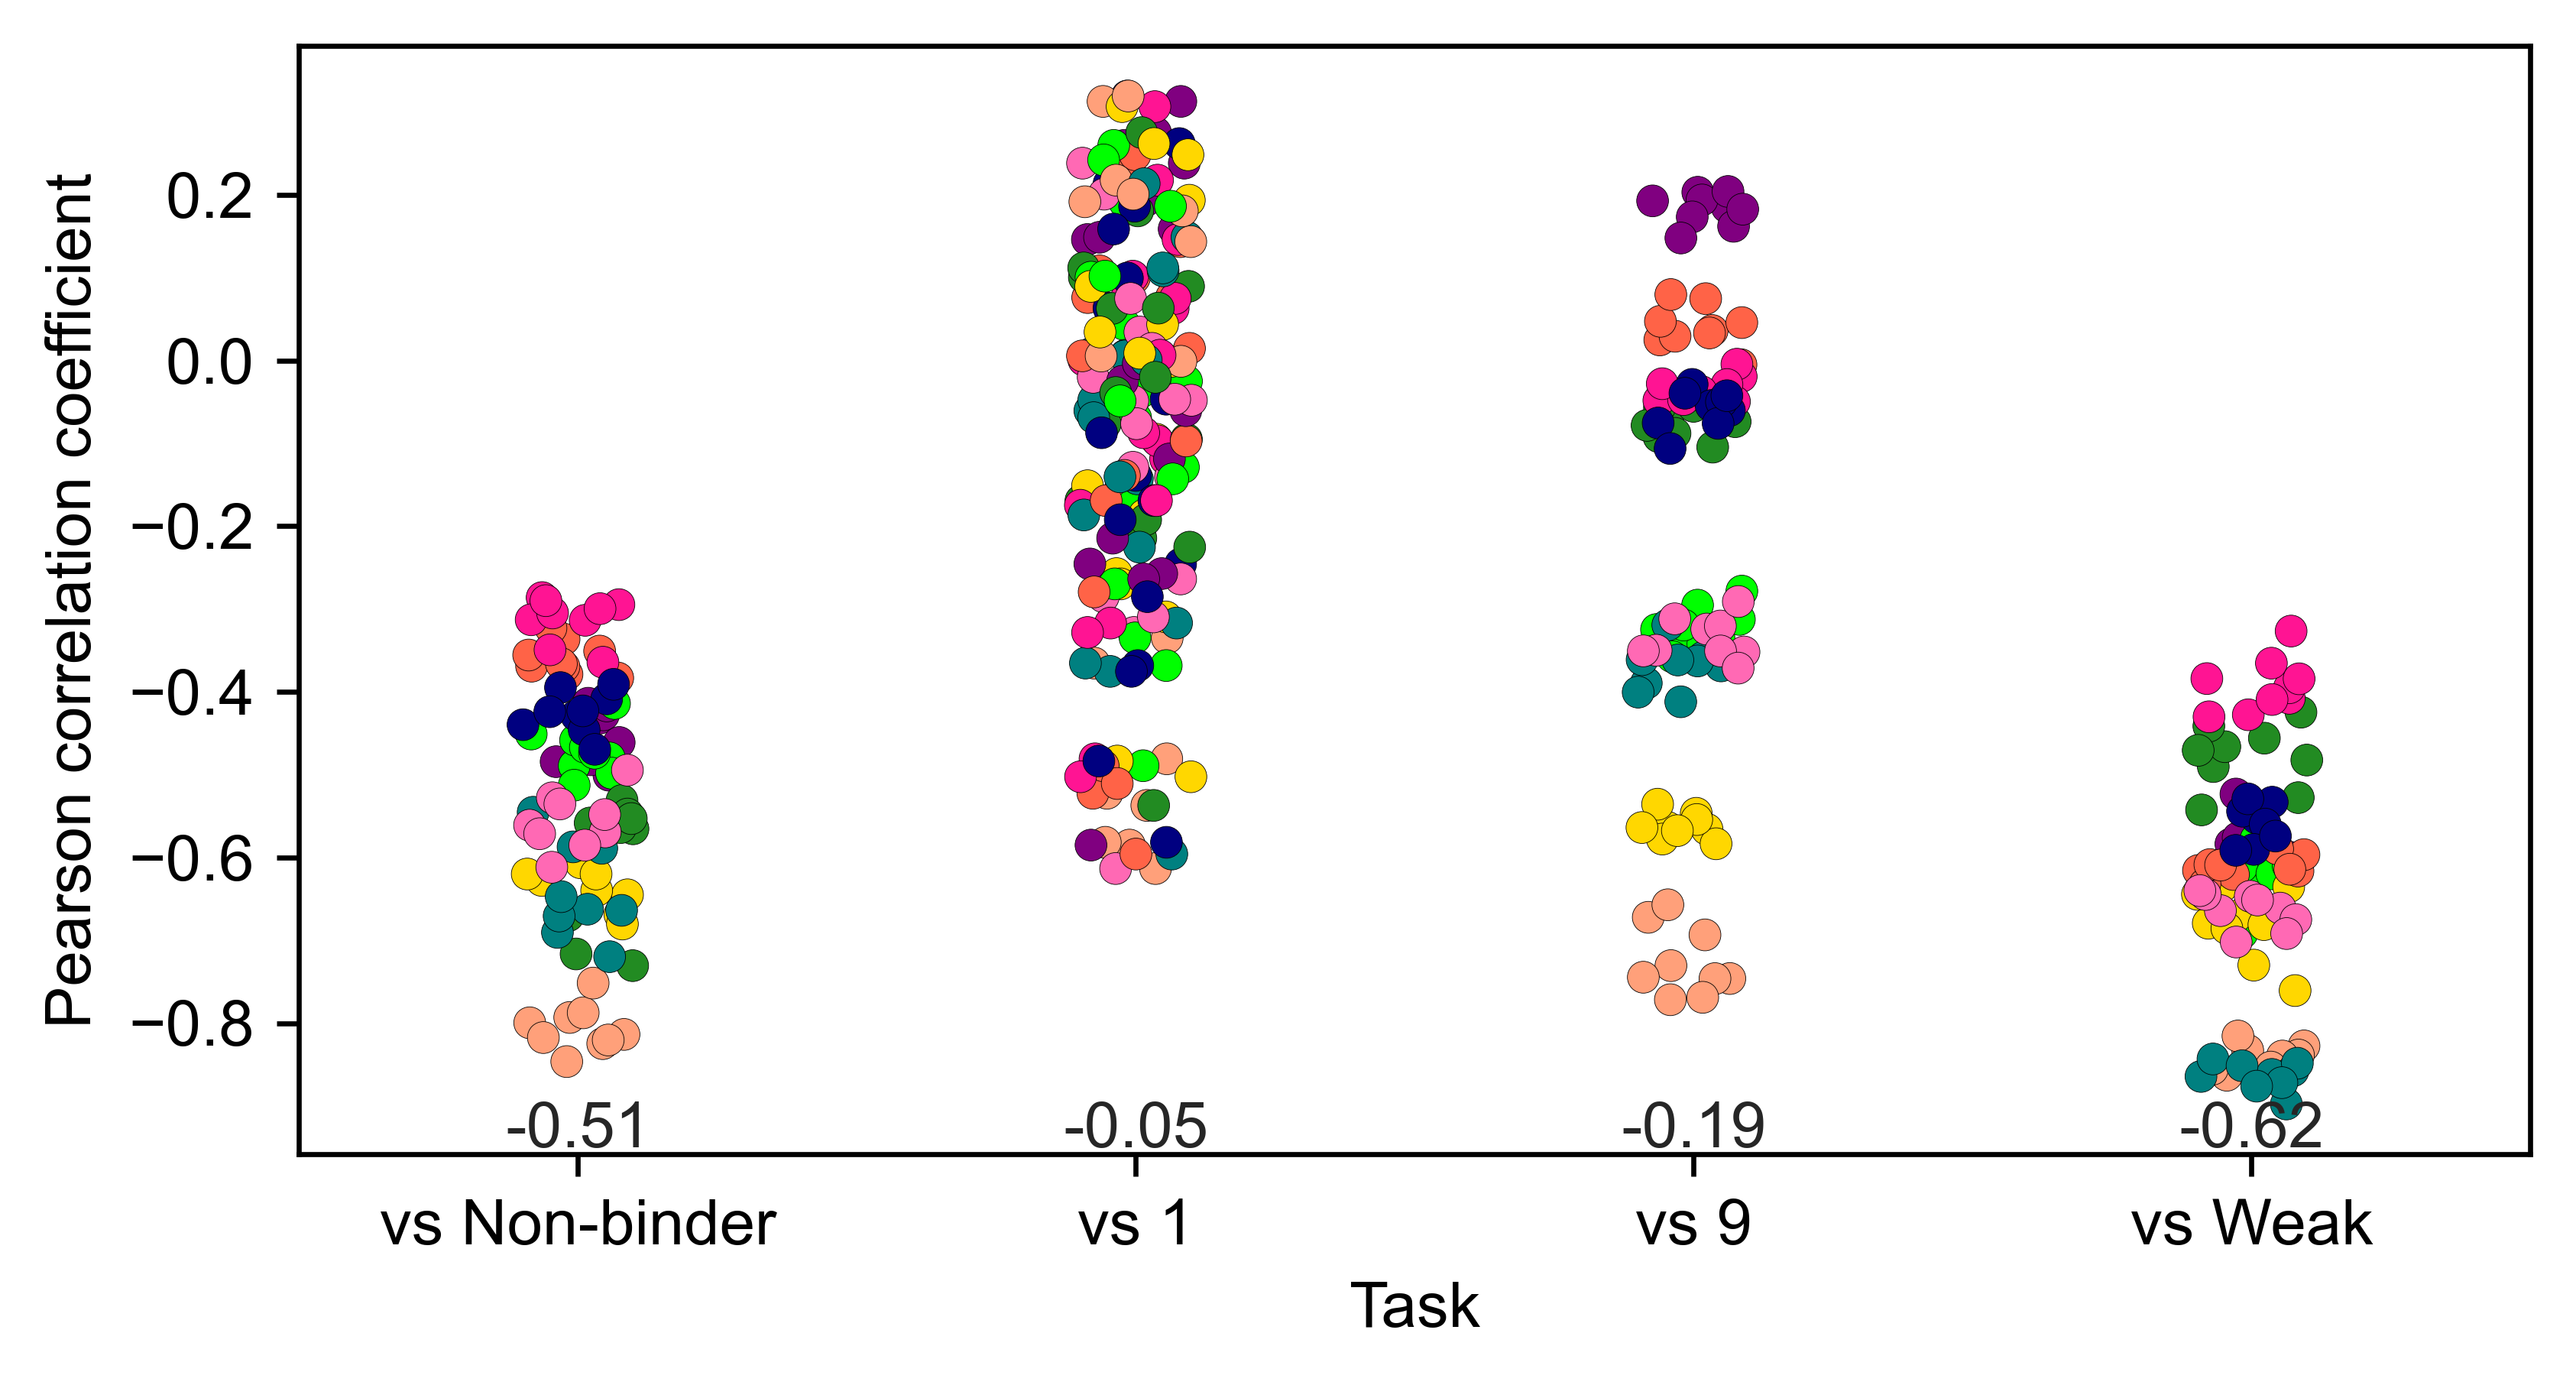

In [12]:
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)
# sns.set_theme(context="paper")
# sns.set_style("white")
sns.set_style("white")
sns.set_style('ticks')

task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
sns.stripplot(
    data=df_logits, 
    x="task_type", 
    y="r_pos", 
    hue="ag_pos",
    palette=cmap_ag,
    ax=ax, 
    order=task_order,
    edgecolor = 'black',
    linewidth =  0.1
)

# Display no legend
ax.legend_.remove()

# Relabel xticks
ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))

# Add median r_pos per task
r_median_df = df_logits.groupby(["task_type"]).agg({"r_pos": "median"})
for i, row in r_median_df.iterrows():
    ax.text(
        i,
        -0.95,
        f"{row['r_pos']:.2f}",
        # Center center
        horizontalalignment='center',
    )


ax.set_ylabel("Pearson correlation coefficient")
ax.set_xlabel("Task")
#fig.savefig("figures/section2/fig2_r_logits_energy.svg")

In [13]:
energy_contributions_path = config.DATA_BASE_PATH/"07e_EnergyContributions.tsv"
df_attrib = pd.read_csv(energy_contributions_path, sep="\t")
# Duplicate 1v1 and reverse pos with negative to account for double contributions
df_attrib_1v1 = df_attrib.loc[df_attrib["task_type"] == "1v1"].copy()


In [16]:
"""EXECUTE = False
if EXECUTE:
    attr_to_calc_1v1 = []
    for i, row in df_attrib_1v1.iterrows():
        ag_pos = row['ag_pos']
        ag_neg = row['ag_neg']
        task_1v1 = f'{ag_pos}__vs__{ag_neg}'
        attr_to_calc_1v1.append(task_1v1)

    with open('../data/attr_to_calc_1v1.json','w') as f:
        json.dump(attr_to_calc_1v1, f)
"""

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_79332/75263190.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))


Text(0.5, 0, 'Task')

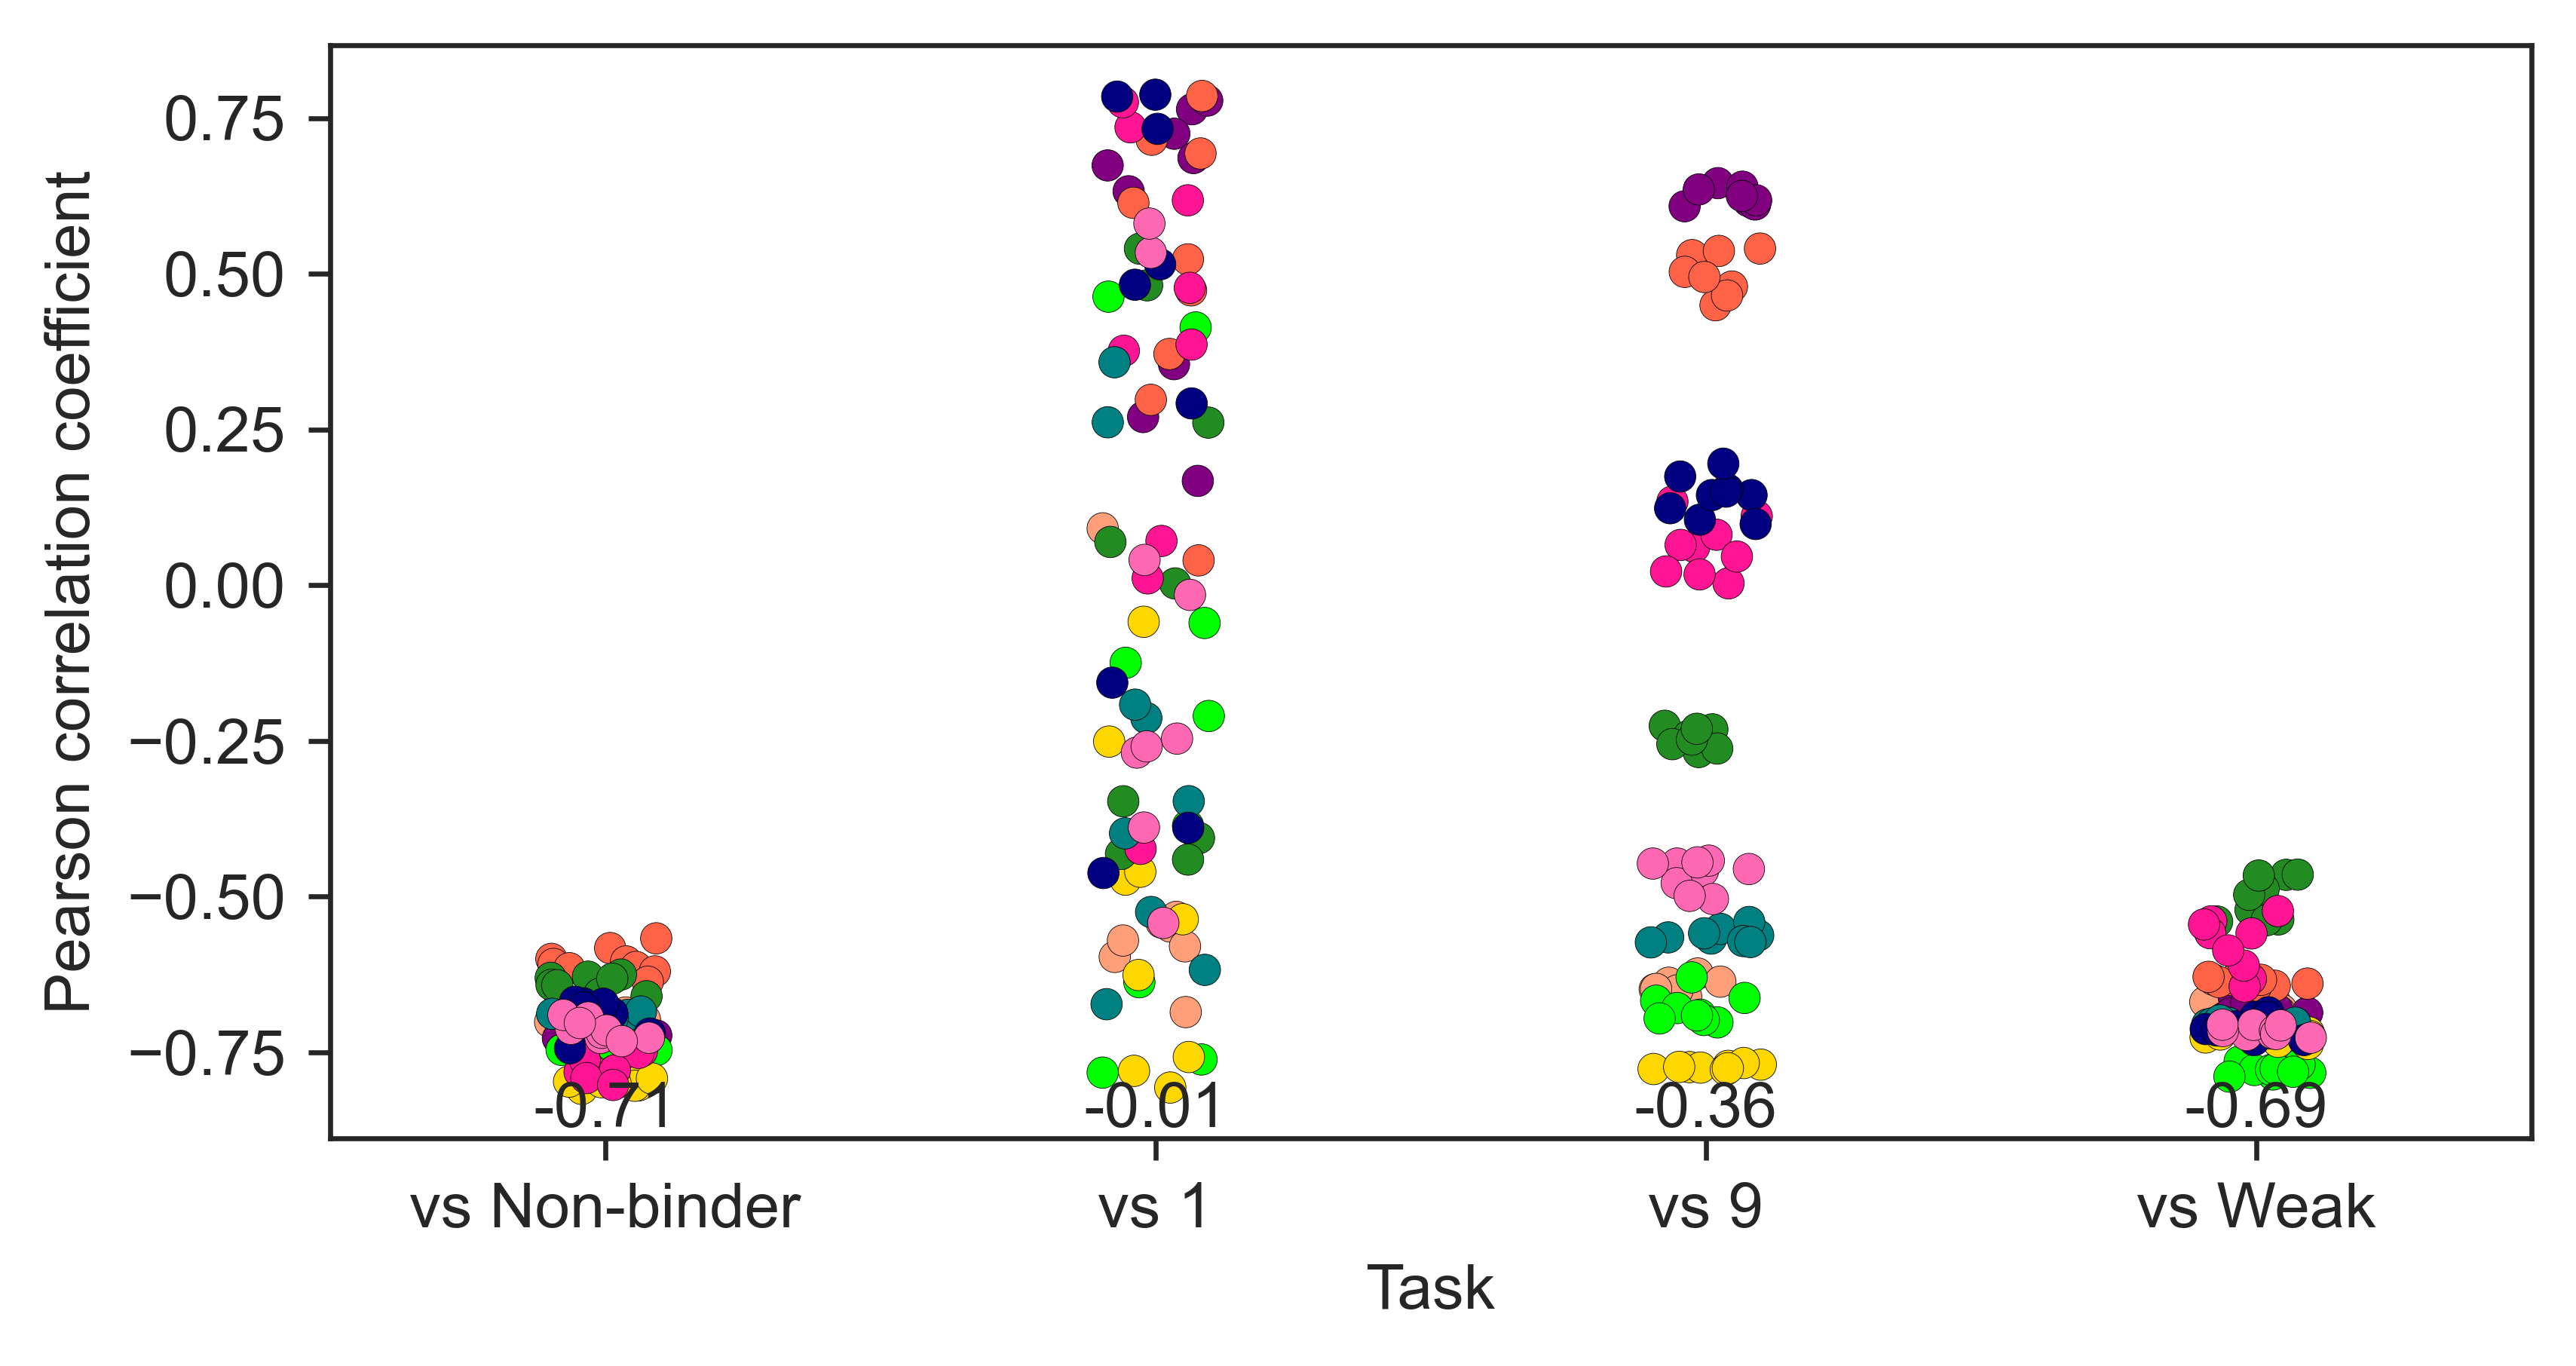

In [15]:
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)
sns.set_style("white")
sns.set_style('ticks')

task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
sns.stripplot(
    data=df_attrib, 
    x="task_type", 
    y="mean_pos_total", 
    order=task_order,
    hue="ag_pos",
    ax=ax,
    palette=cmap_ag,
    edgecolor = 'black',
    linewidth =  0.1
)

ax.legend_.remove()

# Relabel xticks
ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))

# Add median r_pos per task
r_median_df = df_attrib.groupby(["task_type"]).agg({"mean_pos_total": "median"})
for i, row in r_median_df.iterrows():
    ax.text(
        i,
        -0.87,
        f"{row['mean_pos_total']:.2f}",
        # Center center
        horizontalalignment='center',
    )

# ax.set_title("Mean{Correlation(Energycontribution, Attribution)} for positive class")
ax.set_ylabel("Pearson correlation coefficient")
ax.set_xlabel("Task")
#fig.savefig("figures/section2/fig2_r_attr_peraaeng.svg")

In [16]:
#section 2 zoom in plots
fp = config.DATA_BASE_PATH/"fig_2/attribution_records.json"
fp_test_1 = config.DATA_BASE_PATH/"fig_2/high_test_5000.tsv"
fp_test_2 = config.DATA_BASE_PATH/"fig_2/looserX_test_5000.tsv"

df_test_1 = pd.read_csv(fp_test_1, sep="\t")
df_test_1["class"] = "positive"
df_test_2 = pd.read_csv(fp_test_2, sep="\t")
df_test_2["class"] = "negative"
df_test = pd.concat([df_test_1, df_test_2], axis=0)

with open(fp, "r") as f:
    data = json.load(f)

df = pd.DataFrame.from_records(data)
df = pd.merge(df, df_test, left_on="slide", right_on="Slide")

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_79332/11590240.py:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.histplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(-109, -10, 'r = -0.94\n$r^2$ = 0.88')

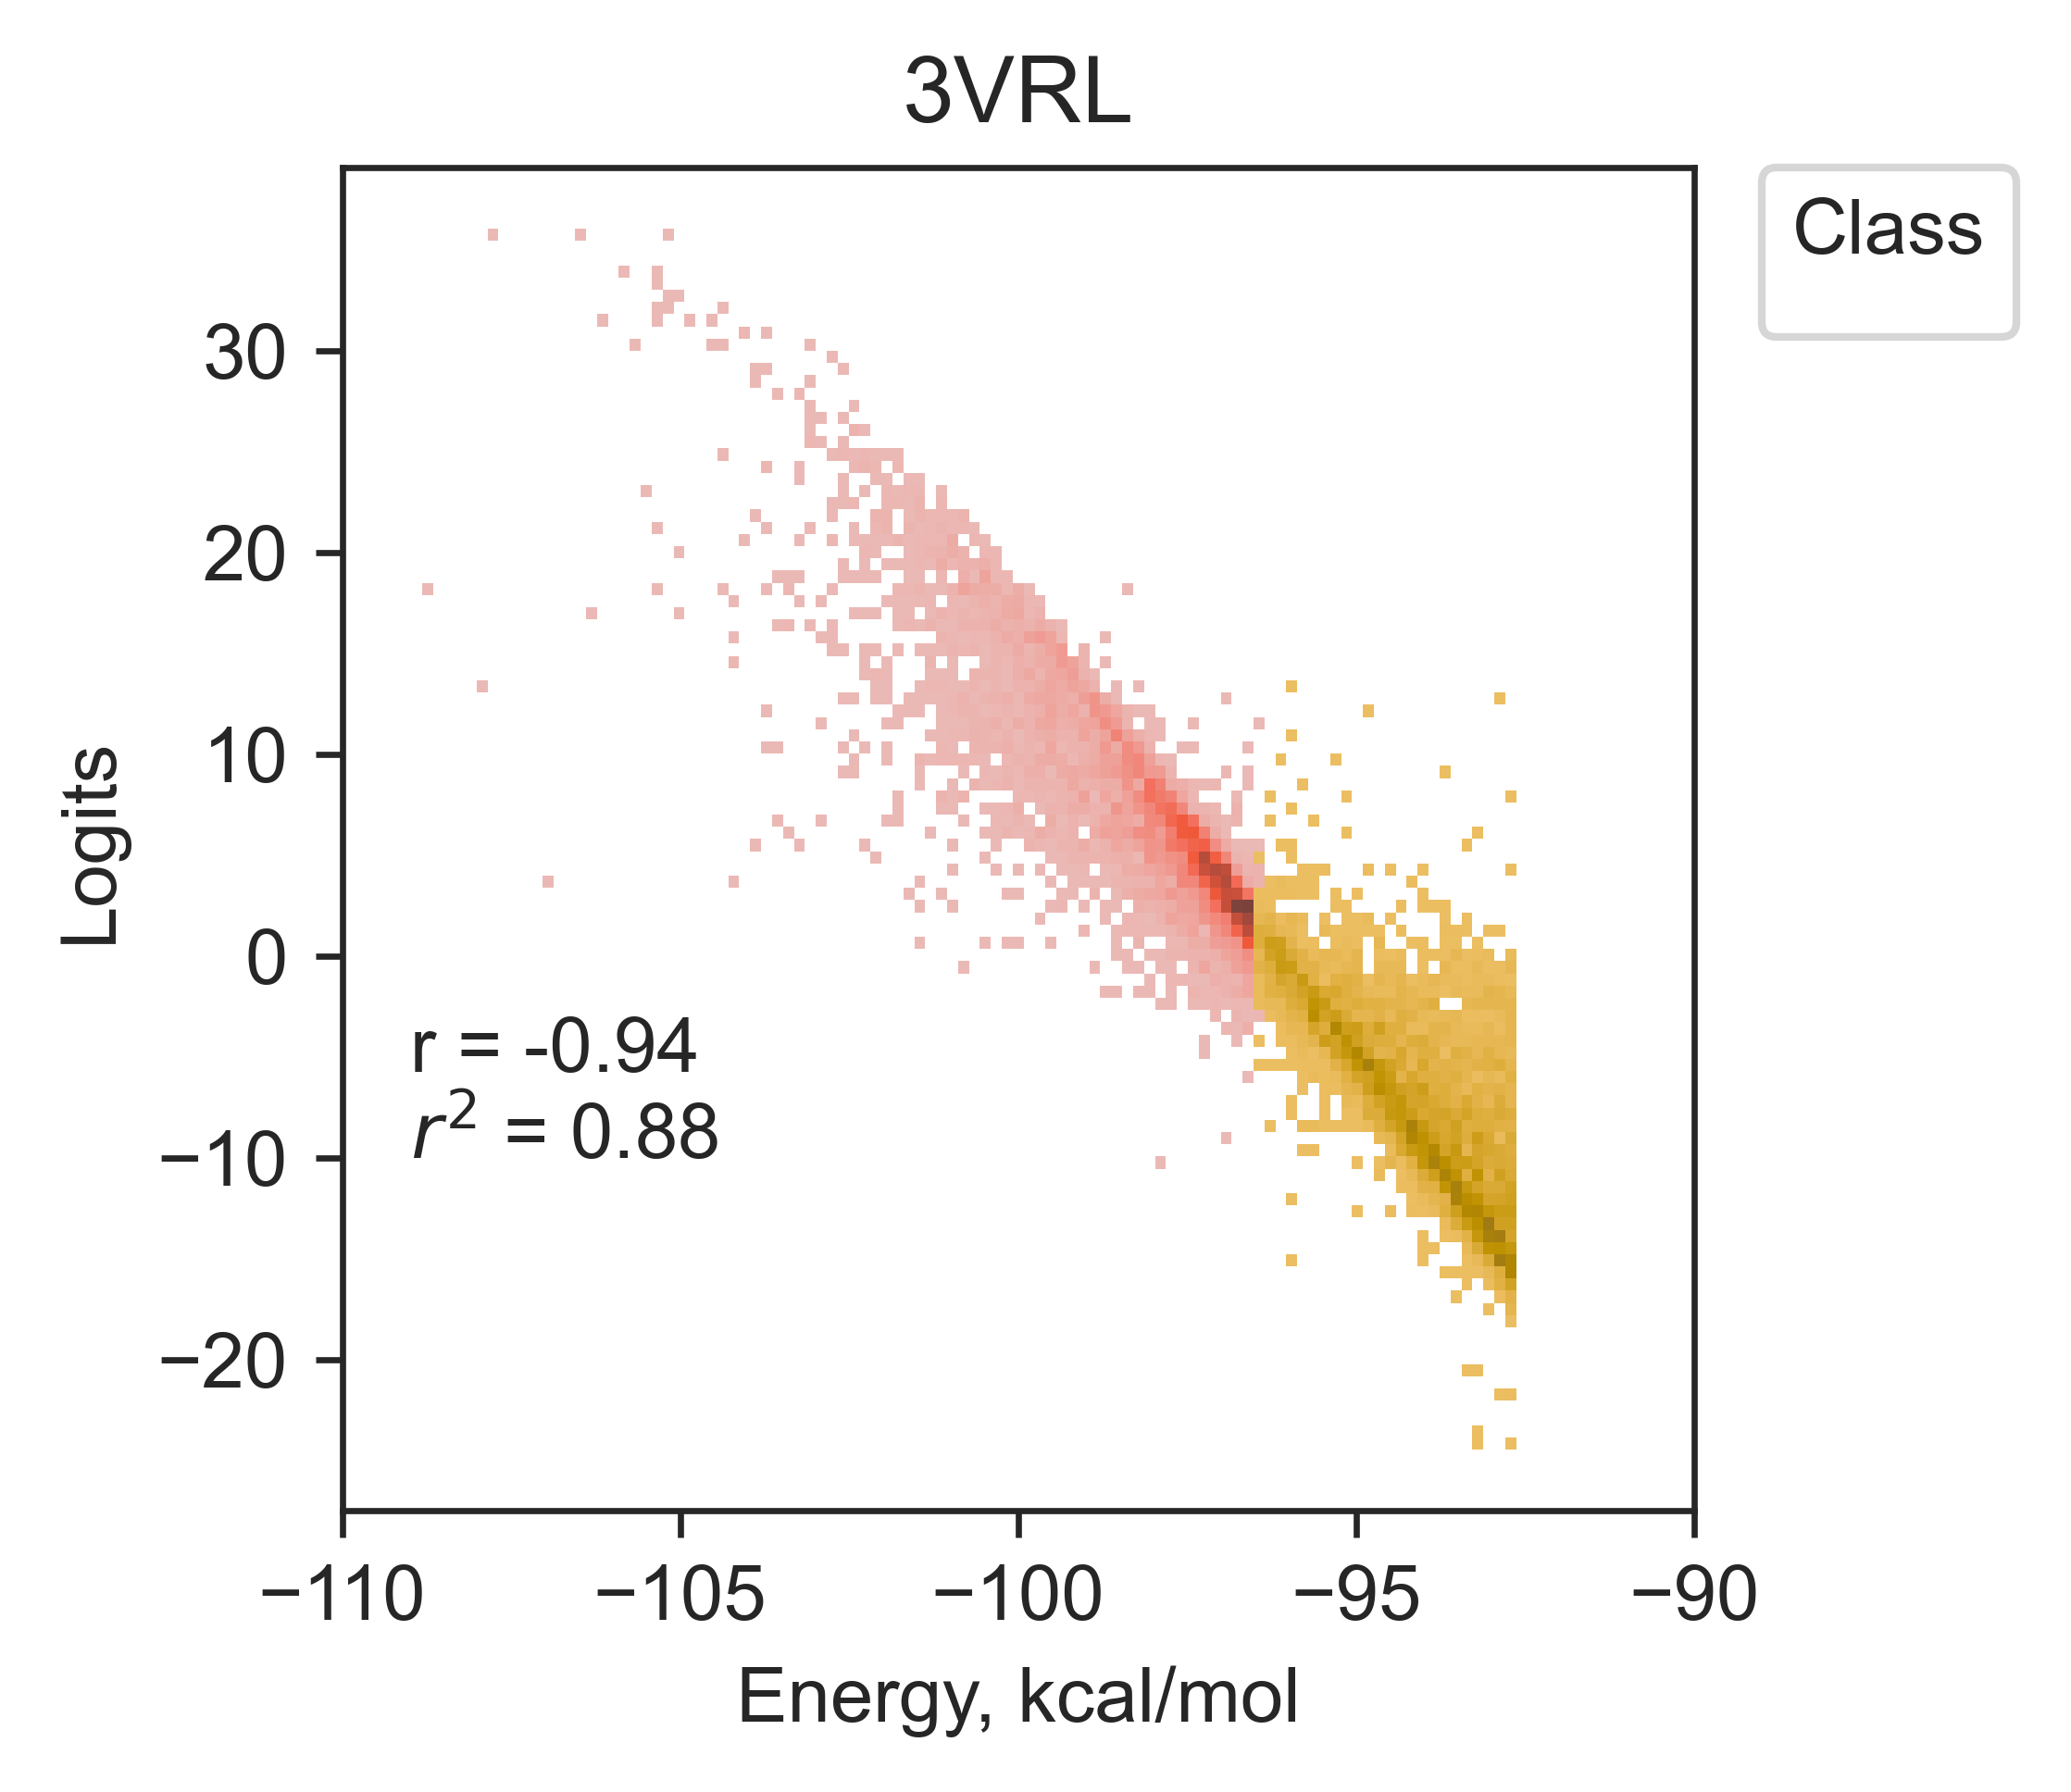

In [17]:
fig, ax = plt.subplots(figsize=(3.14, 3.14), dpi=600)
sns.set_style("white")
sns.set_style('ticks')

cmap = [
    "#f1593a", # red
    "#ffc40d", # yellow
    "#28a3dc", # blue
]

sns.histplot(
    data=df,
    x="Energy",
    y="logits",
    hue="class",
    ax=ax,
    palette=cmap,
    bins=100
)#scatterplot


# Add legend with legend title
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles,
    labels=["Binder", "Weak binder"],
    title="Class",
    loc="upper left",
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0,
)

ax.set_xlabel("Energy, kcal/mol")
ax.set_ylabel("Logits")
ax.set_title("3VRL")
ax.set_xticks(np.arange(-110, -89, 5))

# Add a coefficient of correlation and coeficient of determination
r, p = pearsonr(df["Energy"], df["logits"])
r2 = r ** 2
ax.text(
    -109,
    -10,
    f"r = {r:.2f}\n$r^2$ = {r2:.2f}",
    bbox=dict(facecolor="white", alpha=0.5),
)
#fig.savefig("figures/section2/fig2_r_logits_energy_3VRL.svg")


In [18]:
#join with performance plot
folder_2_task = {'1v9': 'vs 9', 'high_vs_95low': 'vs Non-binder', 'high_vs_looser': 'vs Weak', '1v1': 'vs 1'}
perf_df = pd.read_csv(config.DATA_BASE_PATH/'openset_performance.tsv', sep='\t')
perf_df[['train_task', 'train_ag', 'train_neg', 'seed_id', 'split_id']] = perf_df.task_1.str.split('__', expand=True)
perf_df[['test_task', 'test_ag', 'test_neg', 'test_seed_id', 'test_split_id']] = perf_df.task_2.str.split('__', expand=True)
perf_df.drop(['task_1', 'task_2'], inplace=True, axis=1)
task_rename = {'ONE_VS_NINE': 'vs 9', 'HIGH_VS_95LOW': 'vs Non-binder', 'HIGH_VS_LOOSER': 'vs Weak', 'ONE_VS_ONE': 'vs 1'}
perf_df['train_task'] = perf_df['train_task'].apply(lambda x: task_rename[x])
perf_df['test_task'] = perf_df['test_task'].apply(lambda x: task_rename[x])
df_1vs1 = pd.read_csv(config.DATA_BASE_PATH/'1vs1_perf.tsv', sep='\t', index_col=0)

df_1vs1_open = pd.read_csv(config.DATA_BASE_PATH/'1vs1_perf_open.tsv', sep='\t', index_col=0)
df_1vs1_open['test_neg'] = 'auto'

perf_on_vs1 = pd.read_csv(config.DATA_BASE_PATH/'perf_on_vs1.tsv', sep='\t', index_col=0)
perf_on_vs1.rename(columns={'pos_ag':'train_ag', 'neg_ag':'train_neg', 'pos_ag.1':'test_ag', 'neg_ag.1':'test_neg','prec':'precision'}, inplace=True)
perf_on_vs1.drop(['seed_id.1', 'split_id.1'], inplace=True, axis=1)
perf_on_vs1['train_neg'] = 'auto'
perf_on_vs1['train_task'] = perf_on_vs1['train_task'].apply(lambda x: folder_2_task[x])
#perf_df.drop(columns=['test_split_id', 'test_seed_id'], inplace=True, axis=1)
#df_1vs1_open.drop(columns=['test_split_id', 'test_seed_id'], inplace=True, axis=1)
df_1vs1_open['test_task'] = df_1vs1_open['test_task'].apply(lambda x: folder_2_task[x])
perf_df = pd.concat([perf_df,df_1vs1, df_1vs1_open, perf_on_vs1], axis=0)

perf_open_df = perf_df[perf_df['train_task'] != perf_df['test_task']]
df_closed = perf_df[perf_df['train_task'] == perf_df['test_task']].copy()

In [19]:
df_closed['seed_id'] = df_closed['seed_id'].apply(lambda x: int(x))
df_closed['split_id'] = df_closed['split_id'].apply(lambda x: int(x))

In [20]:
df_logits_perf = df_logits[['task_type', 'ag_pos', 'ag_neg', 'seed_id', 'split_id', 'r_pos']].copy()
df_logits_perf.rename(columns={'task_type':'train_task', 'ag_pos':'train_ag', 'ag_neg':'train_neg'}, inplace=True)
df_logits_perf['train_task'] = df_logits_perf['train_task'].apply(lambda x: folder_2_task[x])

In [21]:
df_logits_perf = df_logits_perf.merge(df_closed, how='inner', on=['train_task', 'train_ag', 'train_neg', 'seed_id', 'split_id'])

In [22]:
for task in df_logits_perf['train_task'].unique():
    df = df_logits_perf[df_logits_perf['train_task'] == 'task']

In [23]:
def seed_split_dupl_filter(df):
    df['dupl_filter'] = df.apply(lambda row: '_'.join(sorted(row[['train_ag','train_neg']])) + '_' + row['train_task'], axis=1)
    df = df.groupby('dupl_filter').mean()
    df.reset_index(inplace=True)
    df = df.drop_duplicates('dupl_filter')
    df[['train_ag','neg_ag','train_task']] = df.dupl_filter.str.split('_', expand=True)
    return df

In [24]:
df_logits_perf_means = seed_split_dupl_filter(df_logits_perf)

In [25]:
df_logits_perf_means.train_task.value_counts()

vs 1             45
vs 9             10
vs Non-binder    10
vs Weak          10
Name: train_task, dtype: int64

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_79332/4237457845.py:54: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


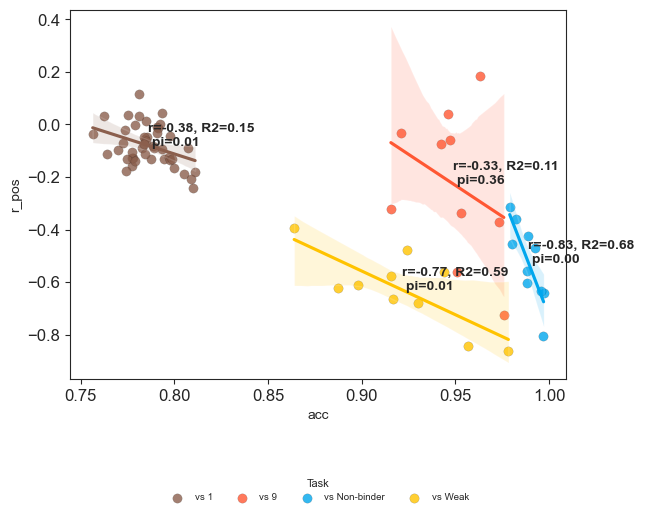

In [27]:
#need this plot
plt.rcParams['svg.fonttype'] = 'none'
cmap = { 'vs 9' : '#FF5733',
         'vs Non-binder':'#00A6ED',
         'vs Weak':'#FFC300',
         'vs 1': '#8B5F4D'}

sns.set_style("white")
sns.set_style('ticks')
fig, ax = plt.subplots()

# Line plot in seaborn with R2 regression
for task, df_g in df_logits_perf_means.groupby("train_task"):
    sns.regplot(
        x="acc",
        y="r_pos",
        data=df_g,
        scatter=True,
        ax=ax,
        label=task,
        color=cmap[task],
        scatter_kws={'edgecolor': 'black', 'linewidth': 0.1, 's':45} 

    )

    # Compute Pearson correlation
    r, pval = pearsonr(df_g["acc"], df_g["r_pos"])
    # Add text with r and R2 at centroid
    x = df_g["acc"].mean()
    y = df_g["r_pos"].mean()
    ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f} \n pi={pval:.2f}" , fontsize=10, fontweight="bold")

FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False)

#get_regression_correlatrion("jsd", "acc", df_jsds_wo_dupl, ax, "Task")

#ax.set_xlabel("Jensen-Shannon Divergence", fontsize=FONT_SIZE)
#ax.set_ylabel(yaxis_title, fontsize=FONT_SIZE)
#yticks = np.arange(0.85, 1.0, 0.05)
#ax.set_yticks(yticks)


# put legend to the bottom
fig.show()
#fig.savefig('./figures/section2/loguts_energy_r.svg')

In [28]:
df_attrib_pred = df_attrib[['task_type', 'ag_pos', 'ag_neg', 'seed_id', 'split_id', 'mean_pos_total']].copy()
df_attrib_pred.rename(columns={'task_type':'train_task', 'ag_pos':'train_ag', 'ag_neg':'train_neg'}, inplace=True)
df_attrib_pred['train_task'] = df_attrib_pred['train_task'].apply(lambda x: folder_2_task[x])

In [29]:
df_attrib_pred = df_attrib_pred.merge(df_closed, how='inner', on=['train_task', 'train_ag', 'train_neg', 'seed_id', 'split_id'])

In [30]:
df_attrib_pred_means = seed_split_dupl_filter(df_attrib_pred)

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_79332/408825964.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


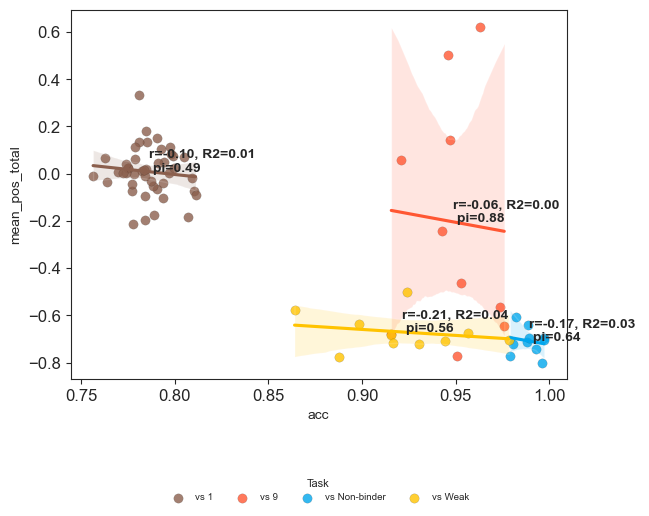

In [31]:
cmap = { 'vs 9' : '#FF5733',
         'vs Non-binder':'#00A6ED',
         'vs Weak':'#FFC300',
         'vs 1': '#8B5F4D'}

sns.set_style("white")
sns.set_style('ticks')
fig, ax = plt.subplots()

# Line plot in seaborn with R2 regression
for task, df_g in df_attrib_pred_means.groupby("train_task"):
    sns.regplot(
        x="acc",
        y="mean_pos_total",
        data=df_g,
        scatter=True,
        ax=ax,
        label=task,
        color=cmap[task],
        scatter_kws={'edgecolor': 'black', 'linewidth': 0.1, 's':45} 

    )

    # Compute Pearson correlation
    r, pval = pearsonr(df_g["acc"], df_g["mean_pos_total"])
    # Add text with r and R2 at centroid
    x = df_g["acc"].mean()
    y = df_g["mean_pos_total"].mean()
    ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f} \n pi={pval:.2f}" , fontsize=10, fontweight="bold")

FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)

#get_regression_correlatrion("jsd", "acc", df_jsds_wo_dupl, ax, "Task")

#ax.set_xlabel("Jensen-Shannon Divergence", fontsize=FONT_SIZE)
#ax.set_ylabel(yaxis_title, fontsize=FONT_SIZE)
#yticks = np.arange(0.85, 1.0, 0.05)
#ax.set_yticks(yticks)


# put legend to the bottom
fig.show()
#fig.savefig('./figures/section2/attr_energy_per_aa.svg')

In [32]:
df_attrib_pred_means.train_task.value_counts()

vs 1             45
vs 9             10
vs Non-binder    10
vs Weak          10
Name: train_task, dtype: int64